# Problem Set 4

_Heliconius_ butterflies are isolated by geography and display striking differences in adaptive wing patterns, which is facilitated by Müllerian mimicry between distantly related species and coupled with divergence between closely related species. _Heliconius_ butterflies frequently hybridize when their respective species ranges overlap and it has been hypothesised that introgression might play an important role in speciation and adaptive radiation. For the final problem set we will first look at global patterns of population structure and differentiation between _Heliconius_ butterflies subspecies and then assess claims about natural selection and introgression at the _optix_ gene—a gene that controls the extreme red wing pattern variation across multiple species of _Heliconius_ and has be implicated as one of the central genes involved in wing pattern mimicry [Jiggins et al. 2017](https://doi.org/10.1098/rstb.2015.0485). To accomplish this we will look at the chromosome 18 data from [Martin et al. 2020](https://doi.org/10.1371/journal.pbio.2006288) which has been already pre-filtered for you __and contains some missing data—i. e. you will need to properly account for missing data throughout all analyses in this problem set.__

![butterflies](data/butterflies.jpg)

__ASSIGNMENT__
- There are four problems all with multiple parts. __NOTE: Problem 4 will require you to move files to and from OSCAR and submit code to the `SLURM` scheduler__
- Do not alter the code in the `Data Processing` section except for changing file paths.
- For all analyses you must write your own code (i. e. you can't use published packages to perform the analyses) like we have done in class.

__HELPFUL HINTS__
- Feel free to add more cells if needed!
- Make sure that you put the images in your `data` directory otherwise a lot of the questions won't make sense!
- Don't forget to consider ploidy and missing genotypes.
- The following papers on [butterfly speciation](https://doi.org/10.1371/journal.pbio.2006288) and [wing pattern evolution](https://doi.org/10.1098/rstb.2015.0485) may be helpful if you are struggling to interpret the results.
- To properly account for missing data during your PCA analyses use `M_mat[np.isnan(M_mat)] = 0` to convert all the `np.nan`'s to 0's in your $M$ matrix.
- Below I have included a list of `numpy` functions that can properly account for missing data that I used to complete the problem set. 
- Take a deep breath, and remember that you are very capable!

__`np.nan` FUNCTIONS__
- [`np.isnan()`](https://numpy.org/doc/stable/reference/generated/numpy.isnan.html)
- [`np.nansum()`](https://numpy.org/doc/stable/reference/generated/numpy.nansum.html)
- [`np.nanmean()`](https://numpy.org/doc/stable/reference/generated/numpy.nanmean.html)
- [`np.nanstd()`](https://numpy.org/doc/stable/reference/generated/numpy.nanstd.html)

In [1]:
# Import modules.
import allel
import h5py
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
from scipy.stats import norm

## Data Processing 

First, I will load the converted vcf file as a HDF5 file and extract the necessary information needed to complete this problem set.

In [2]:
# Load the hdf5 data.
heli_data = h5py.File('./biol1435/data/heli_chr18.h5', mode='r')
# Extract the genotypes.
heli_gt = allel.GenotypeArray(heli_data['calldata/GT'][:])
# Extract the variable positions array.
heli_pos = allel.SortedIndex(heli_data['variants/POS'][:])
# Extract the samples array.
heli_samps = np.array([samp.decode() for samp in heli_data['samples'][:]])

For the selection analyses you will need to perform computations in non-overlapping 50 kb windows. In the cell below I generate a dictionary where the keys correspond to the 50 kb window index and the values correspond to an array of indices that correspond to the window's location in the alternative allele count matrix. I also provide the indices for the _optix_ gene and some helper arrays for plotting.

In [3]:
# Adjust the total chromosome length for 50kb windows.
chr18_adj_len = (16803890 // 50_000) * 50_000
# Intialize a dicctionary with the start and stop position for each window.
wind_dicc = {}
# Intialize a midpoint list.
mid_points = []
# Intialize a window index counter.
index = 0
# For all 50kb window...
for window_start in range(1, 16803890, 50_000):
    # If this is the last window...
    if window_start == 16800001:
        # Break the for loop since there are too few sites in the last window.
        break
    # Else...
    else:
        # Fill the dictionary with the position indices.
        wind_dicc[index] = np.where(((window_start <= heli_pos) & (heli_pos < (window_start + 50_000))))[0]
        # Append the midpoint list.
        mid_points.append(window_start + 25_000)
        # Move the window index forward.
        index += 1
# Determine the optix gene indices.
optix_idx = np.where(((1058778 <= heli_pos) & (heli_pos <= 1159581)))[0]
# Intialize the windows the optix gene is in.
optix_wind = np.array([21, 22, 23])
# Intialize the x-axis ticks.
x_ticks = np.arange(0, 350, 30)
# Intialize the x-axis tick labels.
x_labels = (np.arange(0, chr18_adj_len, 1_500_000) / 1_000_000).astype(str)

Next, I build a metadata dataframe and extract all the sample indices for each of our species.

In [4]:
# Extract the species id from samples labels.
species_id = [sample.split('.')[0] for sample in heli_samps]
# Create a metadata dataframe.
heli_meta_df = pd.DataFrame({'samples': heli_samps, 'species': species_id})
# Extract the unique sample ids.
heli_species = heli_meta_df['species'].unique()
# Subset the focal species.
focal_heli_species = heli_species[:-1]
# Intialize a dictionary to store sample ids.
heli_idx_dicc = {}
# For every species...
for spc in heli_species:
    # Fill the dictionary.
    heli_idx_dicc[spc] = heli_meta_df[heli_meta_df['species'] == spc].index.values

Now, I convert the 3D matrix of genotypes to a 2D matrix (sites X samples) of alternative allele counts and encode missing genotypes as `np.nan`'s. Additionally, I provide you with species specific alternative allele count matrix and alternative allele frequency array in the form of dictionaries, where the keys correspond to the species id and the values correspond the species specific matrix/array.

In [5]:
# Convert the genotypes to an alternative allele count matrix.
heli_aac = heli_gt.to_n_alt(fill=np.nan, dtype=np.float64)
# Intialize an allele count matrix dictionary.
heli_aac_dicc = {}
# intialize a alternative allele frequency dictionary.
heli_freq_dicc = {}
# For every species...
for spc in heli_species:
    # Fill the dictionary with the subsetted alternative allele count matrix.
    heli_aac_dicc[spc] = heli_aac[:, heli_idx_dicc[spc]]
    # Determine the number of chromosomes with allele calls.
    called_chroms = np.count_nonzero(~np.isnan(heli_aac_dicc[spc]), axis=1) * 2
    # Determine the allele counts of the derived/alternative allele.
    per_site_aac = np.nansum(heli_aac_dicc[spc], axis=1)
    # Fill the frequency dictionary.
    heli_freq_dicc[spc] = per_site_aac / called_chroms

Lastly, I provide a butterfly species name dictionary for easier plotting as well as a summary of the number of samples we will be analyzing.

In [6]:
# Intialize a species id dictionary.
heli_name_dicc = {
    'ros': r'$H. \; mel. \; rosina$',
    'mal': r'$H. \; mel. \; malleti$',
    'ama': r'$H. \; mel. \; amaryllis$',
    'chi': r'$H. \; cyd. \; chioneus$',
    'flo': r'$H. \; tim. \; florencia$',
    'nu_sil': r'$H. \; numata$',
}
# Summarize the samples.
heli_meta_df[['species']].aggregate(['value_counts'])

,species
,value_counts
species,
ros,10
mal,10
ama,10
chi,10
flo,10
nu_sil,2


## Population Structure & Differentiation
Our dataset includes the following five focal species:
- _H. melpomene malleti_ (mal; n=10)
- _H. melpomene rosina_ (ros; n=10)
- _H. melpomene amaryllis_ (ama; n=10)
- _H. timareta florencia_ (flo; n=10)
- _H. cydno chioneus_ (chi; n=10)

as well as two samples from an outgroup species—_H. numata_ (nu_sil; n=2)—which we will use for our introgression analyses later on. The following image shows the geographic distribution of these species as well as the species tree describing the overall evolutionary relationships:

![heli_species](./data/heli_species.png)

In this section you will validate the species-level relationships described in the diagram above, but first spend a few minutes to understand the relationships between the different butterfly species and how they are geographically distributed.

### PCA

__(1a)__ Perform a PCA on all samples excluding the two _H. numata_ samples and plot the samples in PC-space. In three sentences or less please interpret your plot being sure to answer the following questions: Does the PCA reflect the overall species-level relationships from the diagram above? Are there any species that seem less distinguishable? __NOTE: since we have missing genotypes that are encode as `np.nan` in our alternative allele count matrix you will need to set all `np.nan`'s to 0 after finding the standernized allele count matrix—if you don't your covariance matrix will be all `np.nan`'s and you won't be able to perform eigendecomposition.__

In [7]:
print(np.nan_to_num(heli_aac_dicc['ros'], nan=0))
print(heli_freq_dicc['ros'])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.         0.         0.16666667 ... 0.         0.         0.        ]


In [8]:
ros_aac = np.nan_to_num(heli_aac_dicc['ros'], nan=0)
mal_aac = np.nan_to_num(heli_aac_dicc['mal'], nan=0)
ama_aac = np.nan_to_num(heli_aac_dicc['ama'], nan=0)
chi_aac = np.nan_to_num(heli_aac_dicc['chi'], nan=0)
flo_aac = np.nan_to_num(heli_aac_dicc['flo'], nan=0)

all_aac = np.concatenate((ros_aac, mal_aac, ama_aac, chi_aac, flo_aac), axis=1)

In [9]:

# Calculate the column mean vector.
mu_vec = np.mean(all_aac, axis=0)
# Calculate the column allele frequency vector.
p_vec = mu_vec / 2
# Calculate the standard deviation vector.
std_vec = np.sqrt(((all_aac.shape[0] * 2) * p_vec * (1 - p_vec)))
# Convert the C matrix to a zero centered M matrix.
M_mat = (all_aac - mu_vec) / std_vec

In [10]:
# Compute the covariance matrix.
X_mat = np.cov(M_mat, rowvar=False)

In [11]:
# Compute the eigen -values and -vectors.
eig_vals, eig_vecs = np.linalg.eig(X_mat)
# Sort the -values and -vectors.

# Sort the eigen vales and pick the corresponding eigen vectors (Principal components)
eig_idx = np.argsort(eig_vals)[::-1]
eig_vals = eig_vals[eig_idx]
eig_vecs = eig_vecs[:, eig_idx]

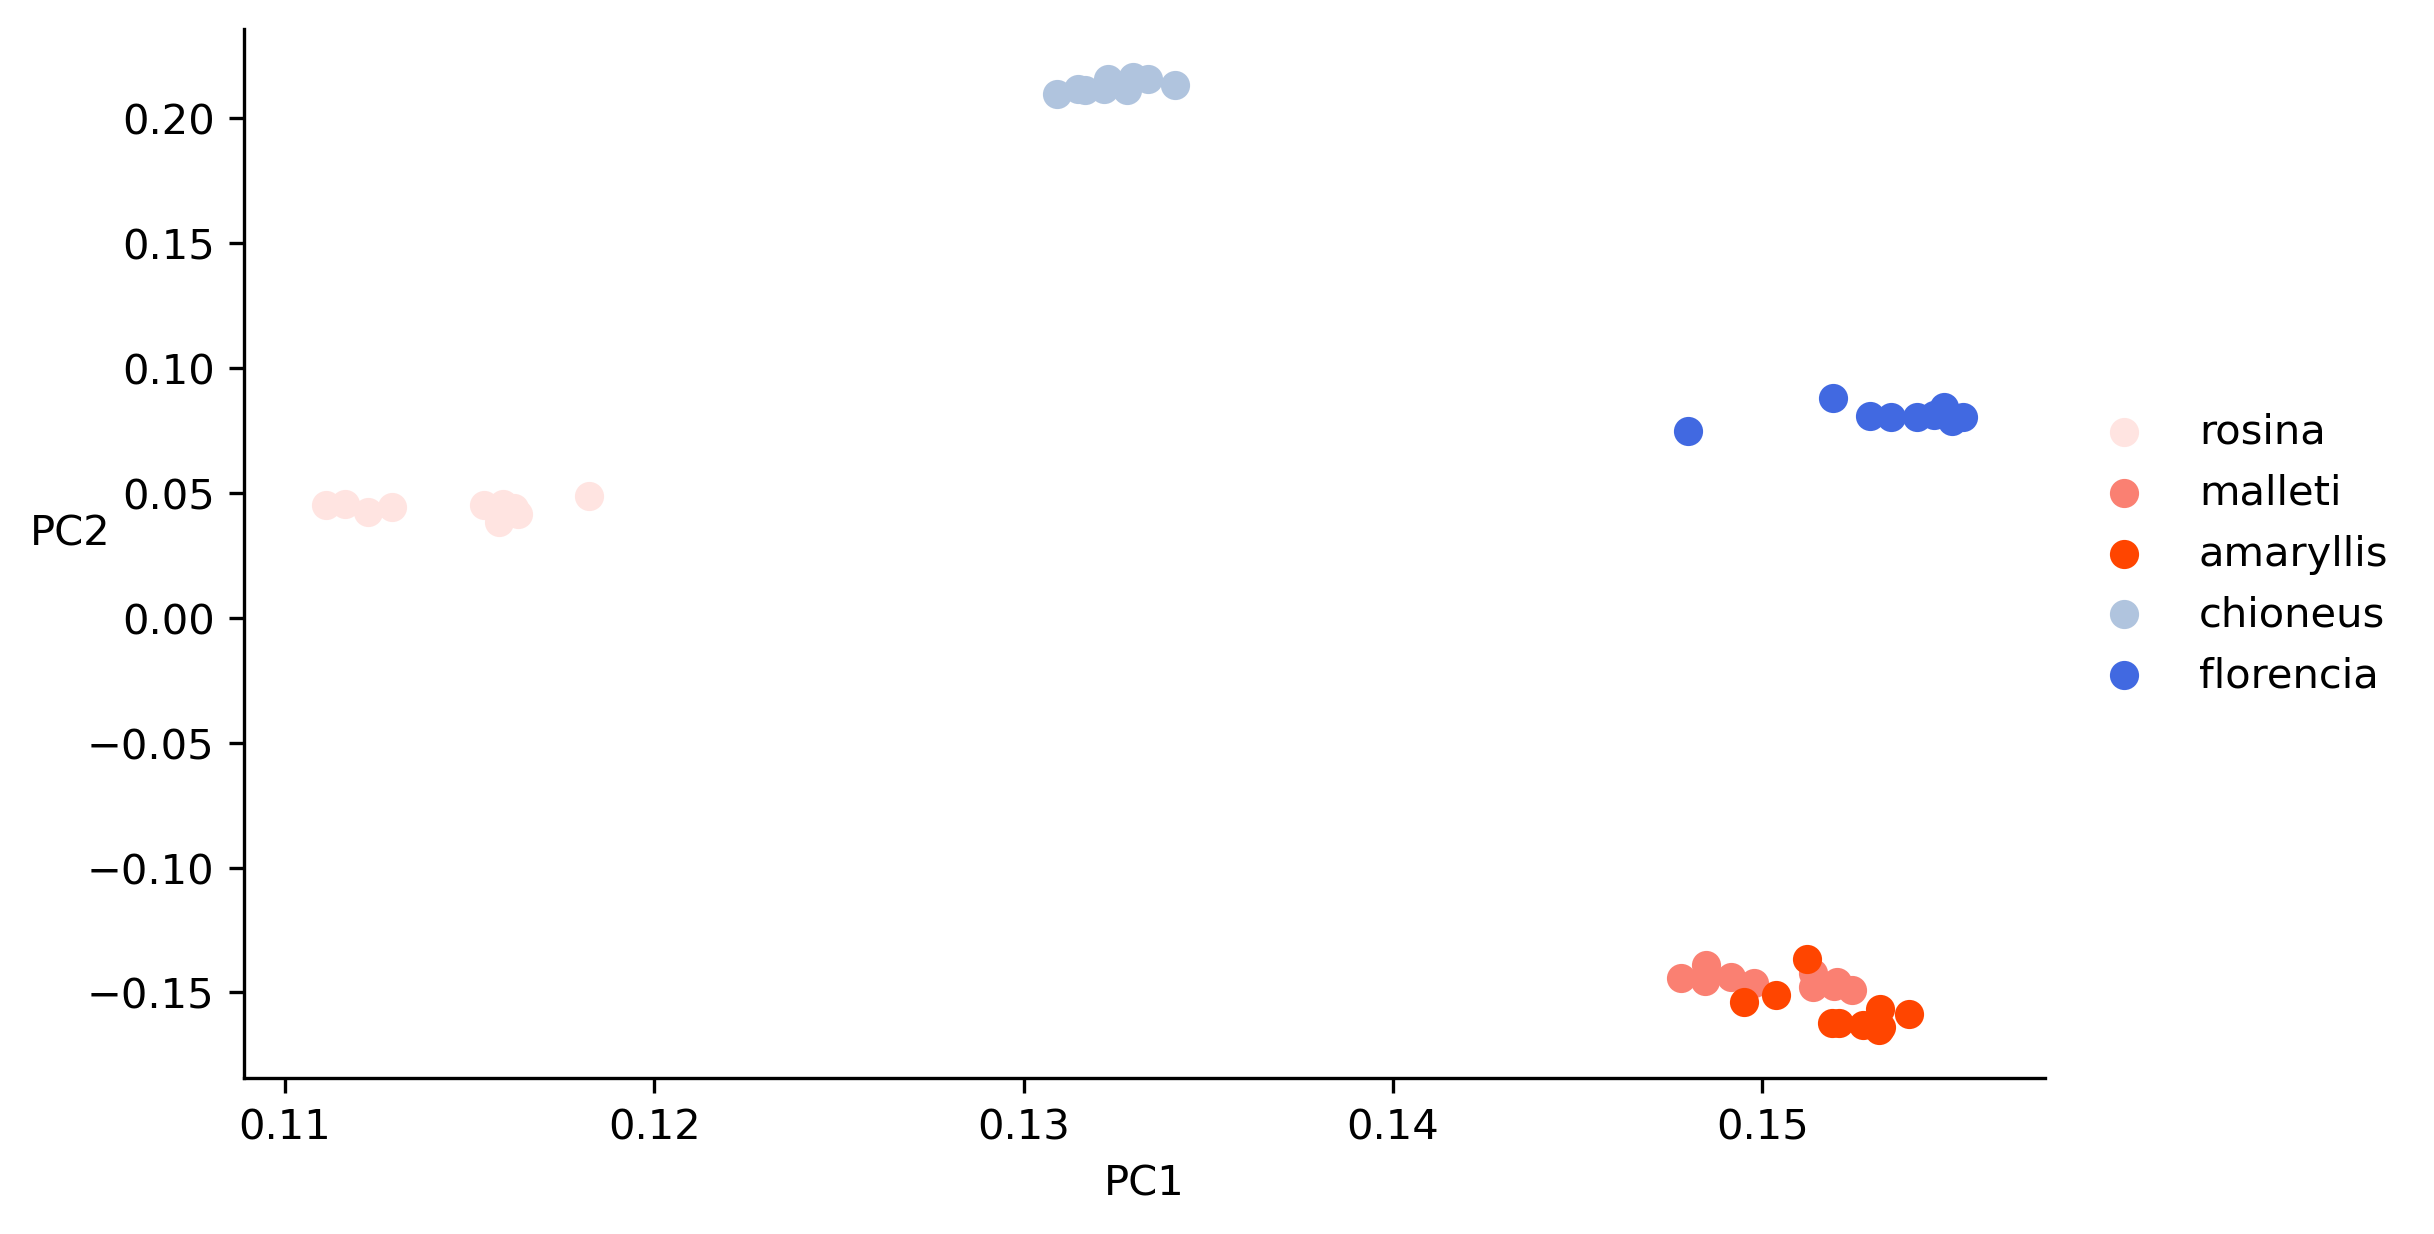

In [12]:
## PLOTTING ##

# Intialize the figure.
fig = plt.figure(figsize=(8, 4), constrained_layout=True, dpi=300)
# Intialize the axes.
ax = fig.add_subplot(111)

# Plot rosina, malleti, amaryllis, chioneus, florencia.
ax.scatter(
    eig_vecs[:10, 0], eig_vecs[:10, 1],
    color='mistyrose', label='rosina',
)
ax.scatter(
    eig_vecs[10:20, 0], eig_vecs[10:20, 1],
    color='salmon', label='malleti',
)
ax.scatter(
    eig_vecs[20:30, 0], eig_vecs[20:30, 1],
    color='orangered', label='amaryllis',
)
ax.scatter(
    eig_vecs[30:40, 0], eig_vecs[30:40, 1],
    color='lightsteelblue', label='chioneus',
)
ax.scatter(
    eig_vecs[40:50, 0], eig_vecs[40:50, 1],
    color='royalblue', label='florencia',
)

# Despine the axes.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Plot the legend.
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
# Label the axes.
plt.xlabel('PC1')
plt.ylabel('PC2', rotation=0)
# Show!
plt.show()

## Plot interpretation
The plot does seem to confirm the evolutionary relationships inferred by the diagram shown above. The blue subspecies of _H. cybno_ seem to cluster closer together than the red subspecies of _H. melpomene_. Given the phylogenetic tree, it make sense that the red subspecies _H. melpomene rosina_ clusters farther from the other two _melpomene_ subspecies, who form a smaller clade within the species. However, these remaining two groups (_H. m. malleti_ and _H. m. amaryllis_) are nearly indistinguishable and cluster on top of one another, which is interesting to note. 

__(1b)__ If you performed your PCA analyses correctly you will notice that _H. melpomene malleti_ and _H. melpomene amaryllis_ cluster together on the PCA despite being geographically distinct "subspecies" with distinct wing patterns—ie they _should_ seperate into different clusters in PC-space. Perform a PCA on just the _H. melpomene malleti_ and _H. melpomene amaryllis_ samples and plot the samples in PC-space. In three sentences or less please interpret your plot being sure to answer the following questions: Do the two subspecies still cluster together? How and why is the PCA different (or not) from your previous PCA?

In [14]:
mal_aac = np.nan_to_num(heli_aac_dicc['mal'], nan=0)
ama_aac = np.nan_to_num(heli_aac_dicc['ama'], nan=0)

subset_aac = np.concatenate((mal_aac, ama_aac), axis=1)

In [15]:
# Calculate the column mean vector.
mu_vec = np.mean(subset_aac, axis=0)
# Calculate the column allele frequency vector.
p_vec = mu_vec / 2
# Calculate the standard deviation vector.
std_vec = np.sqrt(((subset_aac.shape[0] * 2) * p_vec * (1 - p_vec)))
# Convert the C matrix to a zero centered M matrix.
M_mat = (subset_aac - mu_vec) / std_vec

In [16]:
# Compute the covariance matrix.
X_mat = np.cov(M_mat, rowvar=False)

In [17]:
# Compute the eigen -values and -vectors.
eig_vals, eig_vecs = np.linalg.eig(X_mat)
# Sort the -values and -vectors.

# Sort the eigen vales and pick the corresponding eigen vectors (Principal components)
eig_idx = np.argsort(eig_vals)[::-1]
eig_vals = eig_vals[eig_idx]
eig_vecs = eig_vecs[:, eig_idx]

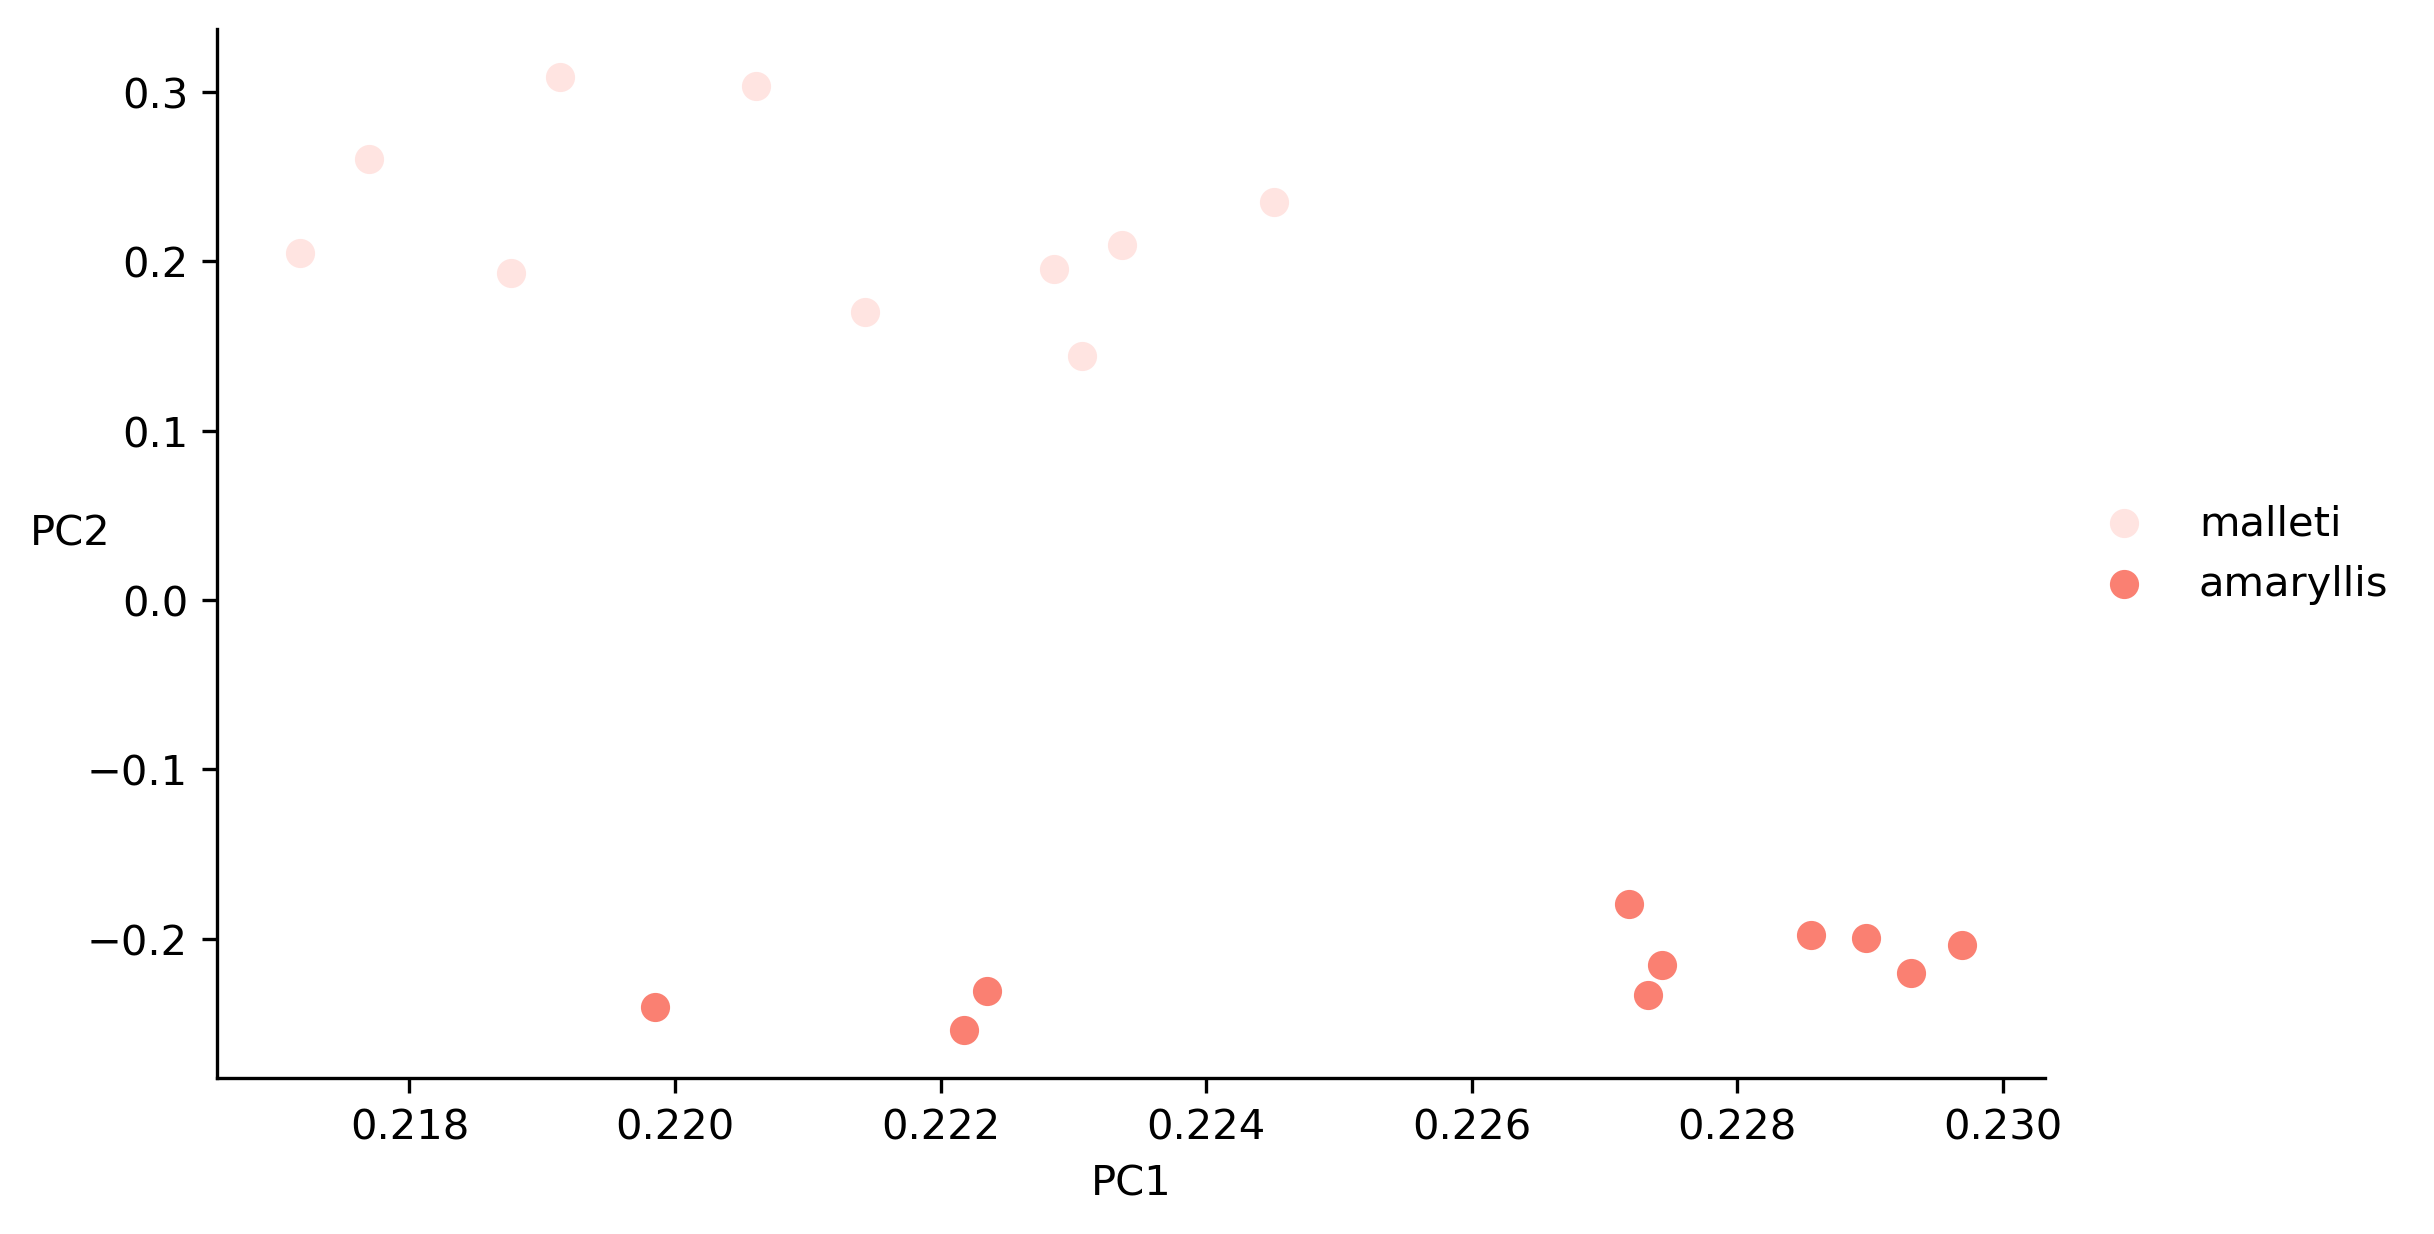

In [18]:
## PLOTTING ##

# Intialize the figure.
fig = plt.figure(figsize=(8, 4), constrained_layout=True, dpi=300)
# Intialize the axes.
ax = fig.add_subplot(111)

# Plot rosina, malleti, amaryllis, chioneus, florencia.
ax.scatter(
    eig_vecs[:10, 0], eig_vecs[:10, 1],
    color='mistyrose', label='malleti',
)
ax.scatter(
    eig_vecs[10:, 0], eig_vecs[10:, 1],
    color='salmon', label='amaryllis',
)

# Despine the axes.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Plot the legend.
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
# Label the axes.
plt.xlabel('PC1')
plt.ylabel('PC2', rotation=0)
# Show!
plt.show()

## Plot interpretation
Here, the two subspecies clearly cluster apart from one another. Unlike the other PCA, this one has a more narrowed scale, so the nuanced difference between the two groups becomes much clearer.

### $F_{ST}$

__(2)__ Compute $F_{ST}$ between all pairwise combinations of species (excluding _H. numata_) and plot the results as a heatmap. In three sentences or less please interpret your plot being sure to address if the pairwise estimates of $F_{ST}$ reflect the species level relationships represented in the diagram above. 

In [25]:
ros_freqs = heli_freq_dicc['ros']
mal_freqs = heli_freq_dicc['mal']
ama_freqs = heli_freq_dicc['ama']
chi_freqs = heli_freq_dicc['chi']
flo_freqs = heli_freq_dicc['flo']

In [ ]:
for sp1 in heli_name_dicc.keys():
    for sp2 in heli_name_dicc.keys():
        if sp1 == sp2:
            continue
        else:
        freq1 
            # Calculate the average gene diversity within the populations.
            H_w = ((md_freqs * (1 - md_freqs)) + (bd_freqs * (1 - bd_freqs)))
            # Calculate the average gene diversity between populations.
            H_b = ((md_freqs * (1 - bd_freqs)) + (bd_freqs * (1 - md_freqs)))

## Selection & Introgression

In the diagram from the previous section you should notice that different butterfly species have different wing patterning and colors. A species' wing patterning is adapted to its enviornment as it signals their distastefulness to local predators. One of the focal genes responsible for the red wing patterning is known as _optix_:

![optix](./data/optix.png)

In this section we will utilize the fact that _H. melpomene malleti_ and _H. melpomene amaryllis_ have different wing patternings to first assess if the gene _optix_ exhibits signtaures consistent with natural selection and then test for signatures of introgression at this gene. To test for local introgression we will use the $D+$ statistic which is conceptually similar _Patterson's D_ except it incorporates both patterns of ancestral and derived allele sharing to assess claims of introgression — read the `"Introduction"` and `"New Approaches"` sections from this [paper](https://www.biorxiv.org/content/10.1101/2022.12.02.518851v1.full) to learn more.

\begin{equation}
D+ \left(P1, P2, P3, P4 \right) = \frac{
    \left(\sum_{i = 1}^{n} C_{ABBA}(i) - C_{BABA}(i) \right) + \left(\sum_{i = 1}^{n} C_{BAAA}(i) - C_{ABAA}(i) \right)
    }{
    \left(\sum_{i = 1}^{n} C_{ABBA}(i) + C_{BABA}(i) \right) + \left(\sum_{i = 1}^{n} C_{BAAA}(i) + C_{ABAA}(i) \right)
    }
\end{equation}

\begin{equation}
D+ = \frac{\sum_{i=1}^{n} [(1 - p_{i1}) p_{i2} p_{i3} (1 - p_{i4}) - p_{i1} (1 - p_{i2}) p_{i3} (1 - p_{i4})] + [p_{i1} (1 - p_{i2}) (1 - p_{i3}) (1 - p_{i4}) - (1 - p_{i1}) p_{i2} (1 - p_{i3}) (1 - p_{i4})]}{\sum_{i=1}^{n} [(1 - p_{i1}) p_{i2} p_{i3} (1 - p_{i4}) + p_{i1} (1 - p_{i2}) p_{i3} (1 - p_{i4})] + [p_{i1} (1 - p_{i2}) (1 - p_{i3}) (1 - p_{i4}) + (1 - p_{i1}) p_{i2} (1 - p_{i3}) (1 - p_{i4})]} 
\end{equation}

__(3a)__ Compute nucleotide diversity (ie [$\pi_{pixy}$](https://doi.org/10.1111/1755-0998.13326)) for both _H. melpomene malleti_ and _H. melpomene amaryllis_, $F_{ST}$ between _H. melpomene malleti_ and _H. melpomene amaryllis_, and $D+$ (see below for the two configurations) in non-overlapping 50 kb windows and then plot all of the results being sure to highlight the _optix_ region (chr18:1058778-1159581). I have included functions to calculate $D+$ and $\pi_{pixy}$ below as well as a skeleton outline for how to iterate through the windows to perform the computations, and subsequent code to plot the windowed results—feel free not to use any of my code but know that it is there :)

_H. melpomene malleti_ $D+$ Configuration
- P1 = _H. cydno chioneus_
- P2 = _H. timareta florencia_
- P3 = _H. melpomene malleti_
- P4 = _H. numata_

_H. melpomene amaryllis_ $D+$  Configuration
- P1 = _H. cydno chioneus_
- P2 = _H. timareta florencia_
- P3 = _H. melpomene amaryllis_
- P4 = _H. numata_

In [ ]:
# Define a function to calculate D+.
def dplus(p1, p2, p3, p4):
    """Returns the D+ value for a given configuration.
    
    pX -- numpy array of alternative allele frequencies.
    """
    # Polarize the alternative allele frequency arrays.
    p1 = np.where(p4 > 0, np.abs(p1 - 1), p1)
    p2 = np.where(p4 > 0, np.abs(p2 - 1), p2)
    p3 = np.where(p4 > 0, np.abs(p3 - 1), p3)
    p4 = np.where(p4 > 0, np.abs(p4 - 1), p4)
    # Calculate site pattern counts.
    abba = np.nansum((1 - p1) * (p2) * (p3) * (1 - p4))
    baba = np.nansum((p1) * (1 - p2) * (p3) * (1 - p4))
    baaa = np.nansum((p1) * (1 - p2) * (1 - p3) * (1 - p4))
    abaa = np.nansum((1 - p1) * (p2) * (1 - p3) * (1 - p4))
    # If the denominator is undefined...
    if ((abba + baba) + (baaa + abaa)) == 0:
        # Set D+ to np.nan.
        dplus = np.nan
    # Else...
    else:
        # Claculate D+.
        dplus = (((abba - baba) + (baaa - abaa)) / ((abba + baba) + (baaa + abaa)))
    return dplus

In [ ]:
# Define a function to calculate nucleotide diversity per site.
def pixy(genotype_matrix):
    """Returns an of array nucleotide diversity for a genotype
       matrix with missing data.

    genotype_matrix -- numpy matrix with a shape of (sites x chromosomes).
    """
    # Determine the number of called genotypes for each site.
    called_genotypes = np.count_nonzero(~np.isnan(genotype_matrix), axis=1) * 2
    # Create a mask where there are no called genotypes.
    mask = called_genotypes == 0
    # Determine the allele counts of the derived/alternative allele.
    derived_allele_count = np.nansum(genotype_matrix, axis=1)
    # Determine the allele counts of the ancestral/reference allele.
    ancestral_allele_count = called_genotypes - derived_allele_count
    # Determine the number of comparisons per site.
    nC2 = np.array([((n * (n - 1)) / 2) for n in called_genotypes])
    # Calculate the numerator.
    numerator = np.nanmean(
        (derived_allele_count[~mask] * ancestral_allele_count[~mask])
    )
    # Calculate the denominator.
    denominator = np.nanmean(nC2[~mask])
    # Calculate pixy.
    pi_pixy = numerator / denominator
    return pi_pixy

In [ ]:
### SKELETON FOR PERFORMING COMPUTATIONS IN WINDOWS ###

# Intialize a dictionary to store the results.
results_dicc = {
    'pi_mal': [], 'pi_ama': [],
    'fst': [], 'dplus_mal': [], 'dplus_ama': [],
}

# For every window...
for idx in wind_dicc.keys():
    # Identify the variable sites indices for the current window.
    wind_sites_idx = wind_dicc[idx]
    
    # Compute pi_{pixy}.
    
    
    
    # Compute Fst.
    

    
    # Compute D+.
    
    
    
    # Fill the dictionary.
    results_dicc['pi_mal'].append()
    results_dicc['pi_ama'].append()
    results_dicc['fst'].append()
    results_dicc['dplus_mal'].append()
    results_dicc['dplus_ama'].append()

In [ ]:
### PLOTTING CODE IF YOU USED MY CODE FROM ABOVE ###

# Intialize the figure and axes.
fig, axes = plt.subplots(
    3, 1, figsize=(12, 9), sharex=True, sharey=False, 
    constrained_layout=True, dpi=300,
)
# Plot nucleotide diversity.
axes[0].plot(
    results_dicc['pi_mal'], color='tab:blue',
    label=heli_name_dicc['mal'],
)
axes[0].plot(
    results_dicc['pi_ama'], color='tab:orange',
    label=heli_name_dicc['ama'],
)
# Plot fst.
axes[1].plot(results_dicc['fst'], color='black')
# Plot D+.
axes[2].plot(results_dicc['dplus_mal'], color='tab:blue')
axes[2].plot(results_dicc['dplus_ama'], color='tab:orange')
axes[2].text(
    90, 0.5, '((({0}, {1}), P3), {2})'.format(
        heli_name_dicc['chi'], heli_name_dicc['flo'], heli_name_dicc['nu_sil'],
    ),
)
# Plot the optix gene region.
axes[0].axvline(
    21, linewidth=15, color='red',
    label=r'$optix$', alpha=0.5,
)
axes[1].axvline(21, linewidth=15, color='red',alpha=0.5)
axes[2].axvline(21, linewidth=15, color='red',alpha=0.5)
# Add the legend.
fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# Set the x-axis.
axes[2].set_xticks(x_ticks)
axes[2].set_xticklabels(x_labels)
axes[2].set_xlabel('Chromosme 18 Position (Mb)')
# Label the y-axes.
axes[0].set_ylabel(r'$\pi$')
axes[1].set_ylabel(r'$F_{ST}$')
axes[2].set_ylabel(r'$D+$')
# Show the plot.
plt.show()

__(3b)__ From your window based plot in three sentences or less explain the overall trends you observe for nucleotide diversity, $F_{ST}$, and $D+$ and then contrast them to what you observe in the _optix_ region. Are the trends you are seeing in the _optix_ region consistent with signatures of natural selction and introgression? Why or why not?

__(4a)__ Using your command line skills securely copy `heli_chr18_100kb_bootstrapping.py` and `perform_heli_bootstrapping.sh` from your local computer to personal directory in our course directory on OSCAR (ie `/gpfs/data/biol1435/`), log on to OSCAR and navigate to your personal directory, using your editor of choice type your email in the `SLURM` header in the `perform_heli_bootstrapping.sh` shell script, and then submit `perform_heli_bootstrapping.sh` to the `SLURM` scheduler. This python script will sample with replacement 1000 bootstrapped windows of 100 kb from chromosome 18 (roughly the size of _optix_) and computes $F_{ST}$ and $D+$ for all bootstrapped windows. After about two minutes or so securley copy the output files (ie `heli_chr18_fst_100kb_bs.csv.gz`, `heli_chr18_dplus_mal_100kb_bs.csv.gz`, and `heli_chr18_dplus_ama_100kb_bs.csv.gz`) from your personal directory to your local computer, and then upload the files to your `data` directory on the Jupyter Hub. Using the `optix_idx` variable that I created for you in the `Data Processing` section compute the observed $F_{ST}$ and $D+$ values for the optix gene and then use the bootstrap distibutions to compute the p-values. __NOTE: For $F_{ST}$ the p-value represents the proportion of bootstrapped replicates with a larger $F_{ST}$ value than what we observed and for $D+$ the p-value represents if our observed $D+$ value is statistically different from 0 after correcting for the mean and standard deviation from our bootstrap distribution (hint: use `scipy.stats.norm.sf()` for $D+$).__

__(4c)__ Plot the bootstrap distibutions for $F_{ST}$ and $D+$, being sure to include a line to designate the observed value for _optix_ as well as the p-value you just computed rounded to three decimal places. Using a significance threshold of 0.05 assess if _optix_ is more differntiated than expected between _H. melpomene malleti_ and _H. melpomene amaryllis_ and if any of our two $D+$ tests are consistent with gene flow between _H. timareta florencia_. Using the references provided in this notebook and the diagram from the first section, why does it make sense that _optix_ is a target of natural selection? Why does it make sense that _optix_ would exhibit signatures of introgression in _H. melpomene malleti_ or _H. melpomene amaryllis_ but not in both configurations? Lastly, do you think _optix_ is a candidate gene for adaptive introgression, why or why not? __Hint: When constructing your final interpretations think back to _optix_'s function and its role in butterfly evolution.__